### Packages

In [1]:
# Load packages

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import os


# Conda packages used for virtual environment:
# pandas numpy geopandas rasterio contextily fiona ipykernel matplotlib seaborn xarray geowombat rasterstats os

### Voter Turnout Data

### Map Ohio Congressional Data

In [9]:
# Unzip Ohio congressional district shapefile data

path = "./project_data/2018_us_cd116"

if not os.path.exists(path):
    with zipfile.ZipFile("./project_data/2018_us_cd116.zip", "r") as zip_ref:
        zip_ref.extractall("./project_data/2018_us_cd116")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped folder already exists. Skipping extraction.


In [10]:
# Get congressional district spatial data
gdf_cd = gpd.read_file("./project_data/2018_us_cd116/tl_2018_us_cd116.shp")

# Filter to Ohio only
gdf_cd = gdf_cd[gdf_cd['STATEFP'] == '39']

# Limit to specified columns
columns_gdf_cd = ['CD116FP', 'GEOID', 'geometry']
gdf_cd = gdf_cd[columns_gdf_cd]

# Preview
print(gdf_cd.head())

    CD116FP GEOID                                           geometry
195      01  3901  POLYGON ((-84.82029 39.15651, -84.82028 39.156...
196      07  3907  MULTIPOLYGON (((-82.46660 40.74394, -82.46618 ...
197      02  3902  POLYGON ((-84.57396 39.21136, -84.57394 39.212...
198      14  3914  POLYGON ((-81.67048 41.31175, -81.67044 41.313...
199      06  3906  POLYGON ((-83.10282 38.88755, -83.10145 38.887...


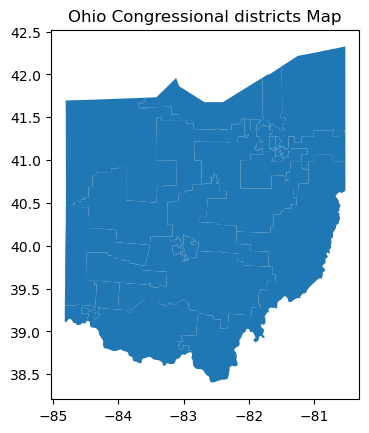

In [11]:
# Reprojecting to epsg:4326

gdf_cd_proj = gdf_cd.to_crs(epsg=4326)

# Map reprojected data
gdf_cd_proj.plot()
plt.title("Ohio Congressional districts Map")
plt.show()

### Performing a spatial join with congressional district and precints

In [12]:
# Joining columns

# Spatial join
gdf_joined = gpd.sjoin(gdf_centroid, gdf_cd_proj, how='right', predicate='within')

# Limit to specified columns
joined_columns = ['Registered Voters', 'Total Voters', 'CD116FP', 'GEOID', 'geometry']
gdf_joined = gdf_joined[joined_columns]

# Preview
gdf_joined.head()

,Registered Voters,Total Voters,CD116FP,GEOID,geometry
195,655,418,01,3901,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."
195,672,441,01,3901,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."
195,1600,772,01,3901,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."
195,2006,1001,01,3901,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."
195,1606,754,01,3901,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."


In [14]:
# Determining Voters turnout per district

# Summing registered voter count & voter turnout count per district
voter_summary = gdf_joined.groupby('CD116FP')[['Registered Voters', 'Total Voters']].sum().reset_index()

# Calculating new column for voter turnout percentage
voter_summary['Voter Turnout Percentage'] = (voter_summary['Total Voters'] / voter_summary['Registered Voters']) * 100

# Extract geometry per CD116FP
geometry_summary = gdf_joined.drop_duplicates('CD116FP')[['CD116FP', 'geometry']]



# Merging back to combine geometry with voter sums
gdf_turnout = voter_summary.merge(geometry_summary, on='CD116FP')

# Converting back to geodataframe
gdf_turnout = gpd.GeoDataFrame(gdf_turnout, geometry='geometry', crs=gdf_joined.crs)

# Preview
#gdf_turnout.head(20)
geometry_summary.head()


,CD116FP,geometry
195,01,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."
196,07,"MULTIPOLYGON (((-82.46660 40.74394, -82.46617 ..."
197,02,"POLYGON ((-84.57396 39.21136, -84.57393 39.212..."
198,14,"POLYGON ((-81.67048 41.31175, -81.67044 41.313..."
199,06,"POLYGON ((-83.10282 38.88755, -83.10145 38.887..."


### Map Voter Turnout Data

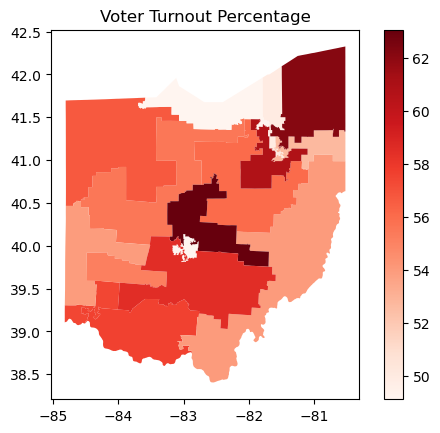

In [14]:
# Mapping geodataframe based on geometry & voter turnout data
gdf_turnout.plot(column='Voter Turnout Percentage', cmap='Reds', legend=True)
plt.title("Voter Turnout Percentage")
plt.show()

### Map Demographic Data

In [15]:
# Function for cleaning data
def clean_cd_data(file_path, rename_dict, columns):
    #Read file
    data = pd.read_csv(file_path,
                          header=2,
                          skiprows=[3,4])
    #Rename columns
    data = data.rename(columns=rename_dict)

    #Filter out non-Ohio data
    data = data[data['State name'] == 'Ohio']

    #Specify columns
    data = data[columns]

    #Add column for geospatial join
    data['CD116FP'] = data['Congressional district'].astype(str).str.zfill(2)

    #Geospatial join
    data = data.merge(geometry_summary, on='CD116FP')

    #Make data a geodataframe
    data = gpd.GeoDataFrame(data, geometry='geometry', crs=gdf_joined.crs)

    return data

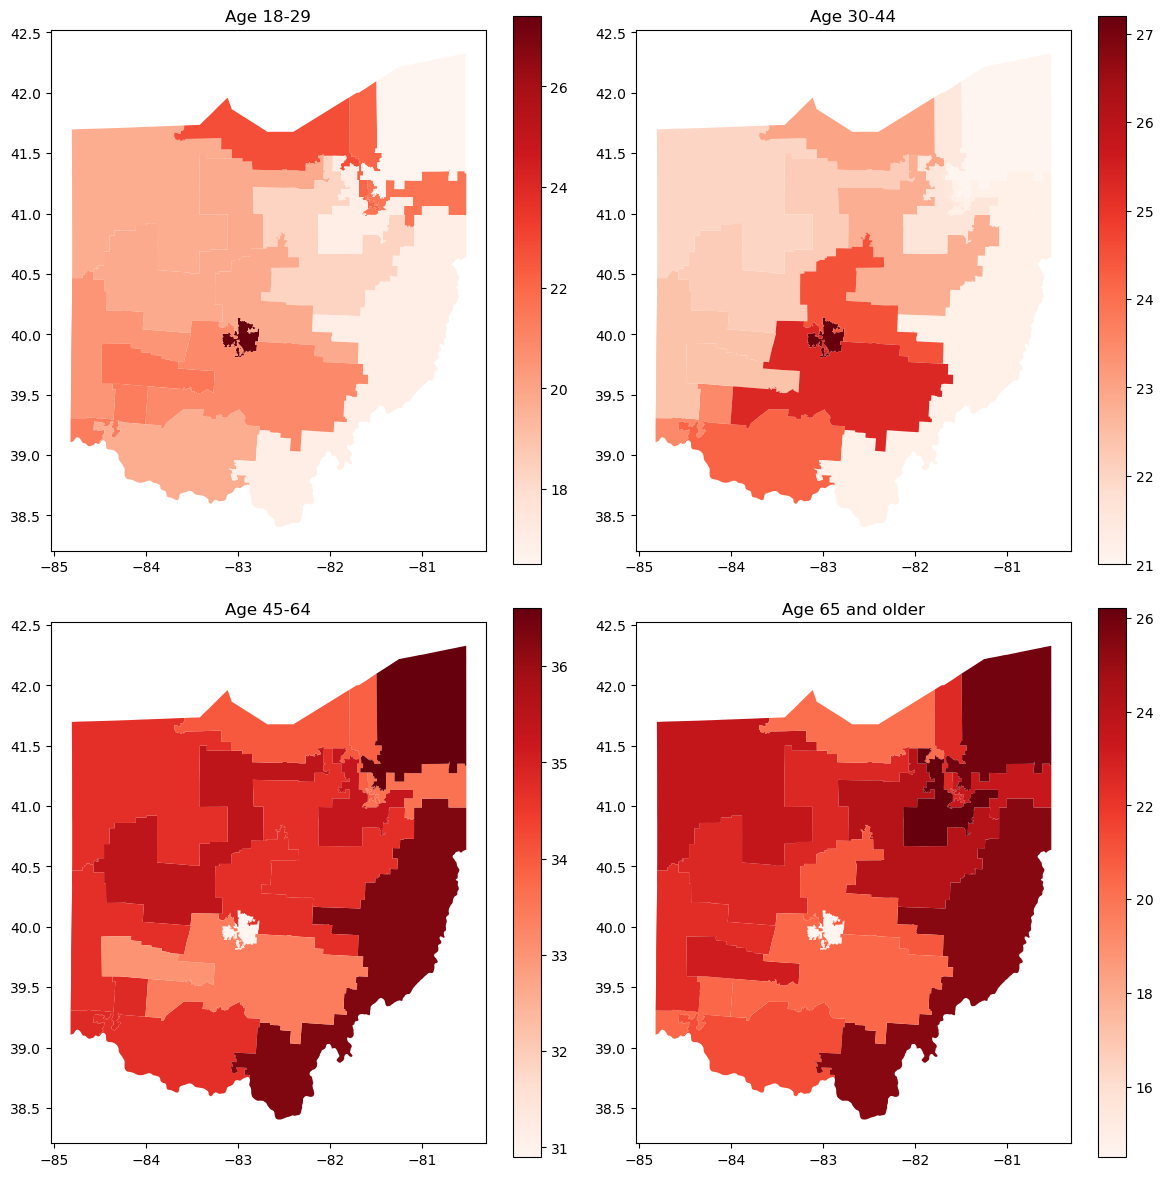

In [16]:
# Age data

# Clean data
age_cd_file = "./project_data/table02a_age_2018.csv"
age_cd_dict = {'Unnamed: 8': '18-29',
    'Unnamed: 12': '30-44',
    'Unnamed: 16': '45-64',
    'Unnamed: 20': '65 and older'}
age_cd_columns = ['State name', 'Congressional district', '18-29', '30-44', '45-64', '65 and older']

age_cd_gdf = clean_cd_data(age_cd_file, age_cd_dict, age_cd_columns)
age_cd_gdf.head()

# Map Data
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Map for '18-29'
age_cd_gdf.plot(column='18-29', cmap='Reds', legend=True, ax=axs[0, 0])
axs[0, 0].set_title("Age 18-29")

# Plot 2: Map for '30-44'
age_cd_gdf.plot(column='30-44', cmap='Reds', legend=True, ax=axs[0, 1])
axs[0, 1].set_title("Age 30-44")

# Plot 3: Map for '45-64'
age_cd_gdf.plot(column='45-64', cmap='Reds', legend=True, ax=axs[1, 0])
axs[1, 0].set_title("Age 45-64")

# Plot 4: Map for '65 and older'
age_cd_gdf.plot(column='65 and older', cmap='Reds', legend=True, ax=axs[1, 1])
axs[1, 1].set_title("Age 65 and older")

# Adjust layout
plt.tight_layout()
plt.show()

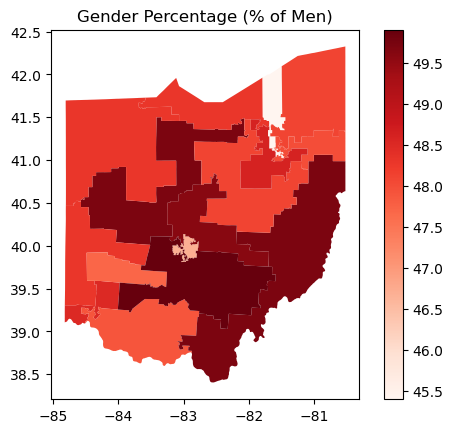

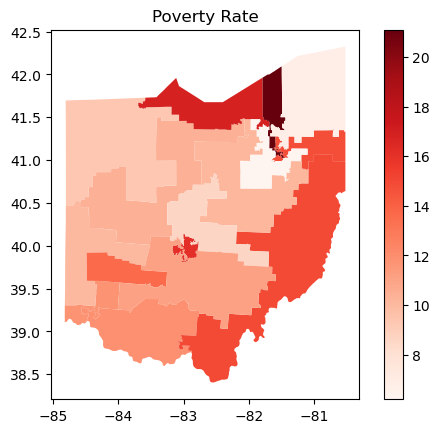

In [17]:
# Sex & Poverty data

# Clean sex & poverty data
sex_poverty_cd_file = "./project_data/table02b_sex_poverty_2018.csv"
sex_poverty_cd_dict = {'Unnamed: 8': 'Men',
    'Unnamed: 12': 'Women',
    'Unnamed: 18': 'In Poverty'}
sex_poverty_cd_columns = ['State name', 'Congressional district', 'Men', 'Women', 'In Poverty']

sex_poverty_cd_gdf = clean_cd_data(sex_poverty_cd_file, sex_poverty_cd_dict, sex_poverty_cd_columns)
sex_poverty_cd_gdf.head(20)

# Map
sex_poverty_cd_gdf.plot(column='Men', cmap='Reds', legend=True)
plt.title("Gender Percentage (% of Men)")
plt.show()

sex_poverty_cd_gdf.plot(column='In Poverty', cmap='Reds', legend=True)
plt.title("Poverty Rate")
# plt.axis('off')
plt.show()

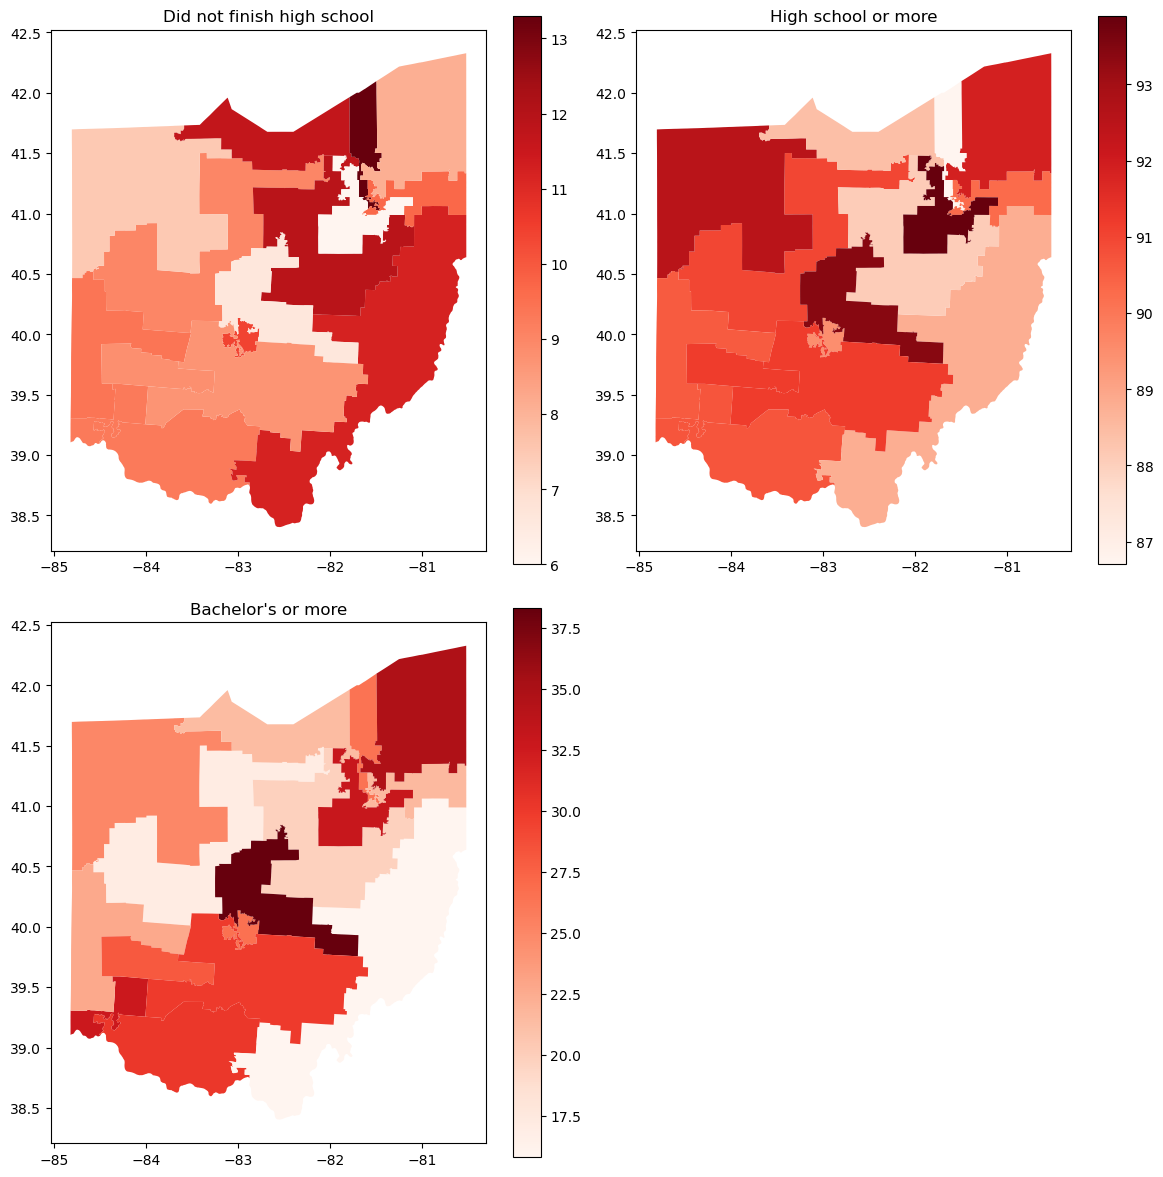

In [18]:
# Education data

data = pd.read_csv('./project_data/table02c_education_2018.csv')
                        #   header=2,
                        #   skiprows=[3,4])

data.head()

# Clean education data
education_cd_file = "./project_data/table02c_education_2018.csv"
education_cd_dict = {'Unnamed: 8': 'Less than 9th grade',
    'Unnamed: 12': '9th to 12 Grade, no diploma',
    'Unnamed: 36': 'High school or more',
    'Unnamed: 40': 'Bachelors or more'}
education_cd_columns = ['State name', 'Congressional district', 'Less than 9th grade', '9th to 12 Grade, no diploma', 'High school or more', 'Bachelors or more']

education_cd_gdf = clean_cd_data(education_cd_file, education_cd_dict, education_cd_columns)

# Making new column combining those that did not finish high school
education_cd_gdf['Did not finish high school'] = (
    education_cd_gdf['Less than 9th grade'] + education_cd_gdf['9th to 12 Grade, no diploma']
)
education_cd_gdf = education_cd_gdf.drop(
    ['Less than 9th grade', '9th to 12 Grade, no diploma'],
    axis=1
)

# Preview
education_cd_gdf.head(20)

# Map
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

education_cd_gdf.plot(column='Did not finish high school', cmap='Reds', legend=True, ax=axs[0, 0])
axs[0, 0].set_title("Did not finish high school")

education_cd_gdf.plot(column='High school or more', cmap='Reds', legend=True, ax=axs[0,1])
axs[0, 1].set_title("High school or more")

education_cd_gdf.plot(column='Bachelors or more', cmap='Reds', legend=True, ax=axs[1, 0])
axs[1, 0].set_title("Bachelor\'s or more")

fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.show()


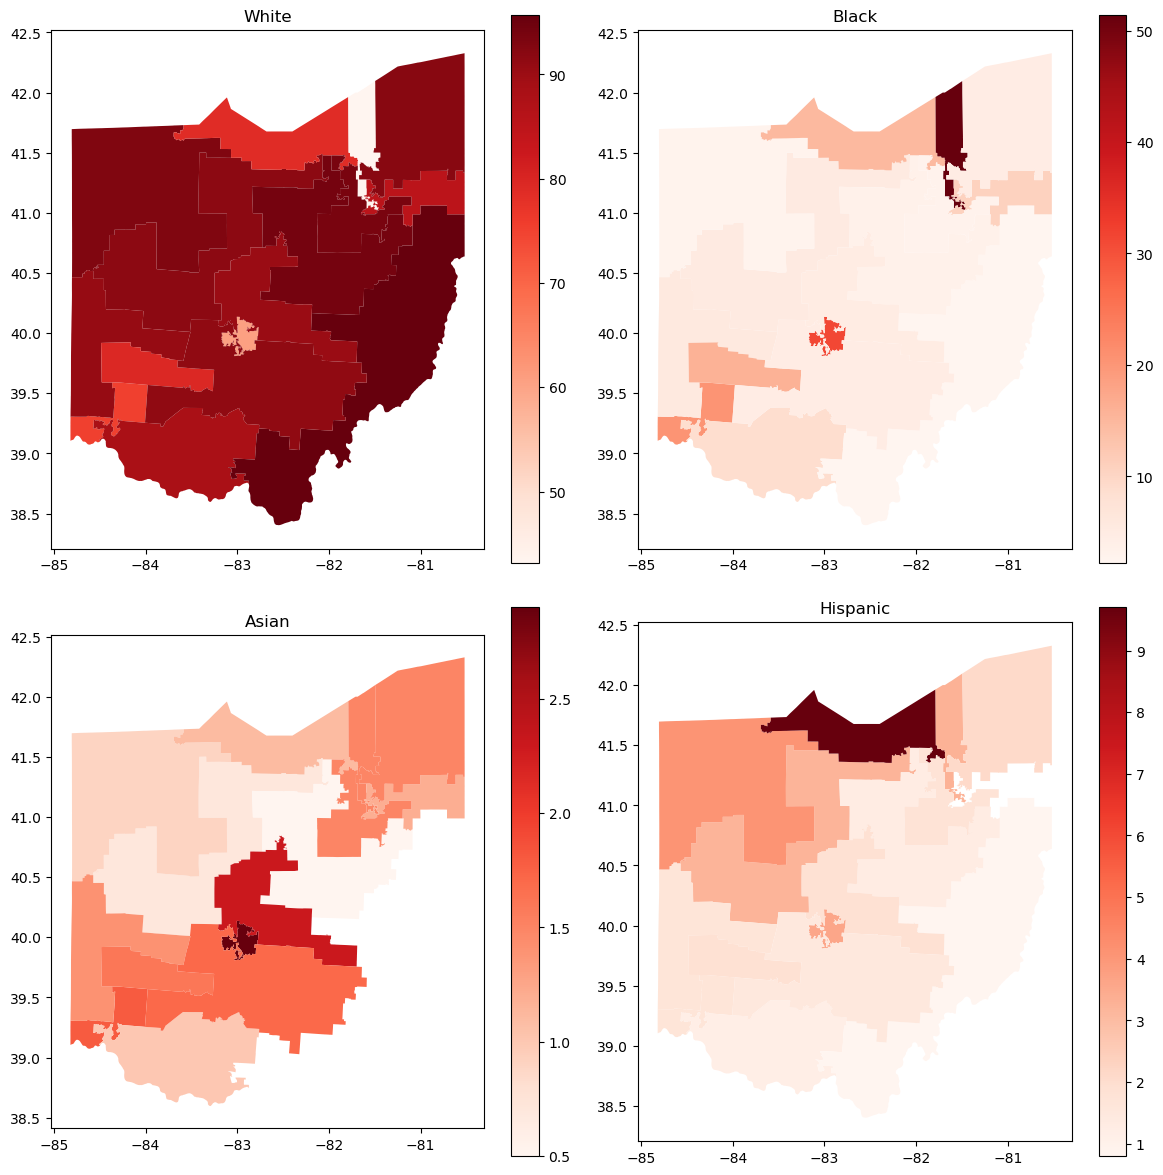

In [19]:
# Race data

data = pd.read_csv('./project_data/table02d_race_2018.csv')
                        #   header=2,
                        #   skiprows=[3,4])

# Clean race data
race_cd_file = "./project_data/table02d_race_2018.csv"
race_cd_dict = {'Unnamed: 8': 'White',
    'Unnamed: 12': 'Black',
    'Unnamed: 16': 'Asian',
    'Unnamed: 36': 'Hispanic'}
race_cd_columns = ['State name', 'Congressional district', 'White', 'Black', 'Asian', 'Hispanic']

race_cd_gdf = clean_cd_data(race_cd_file, race_cd_dict, race_cd_columns)

# Make sure data is numerical
race_cd_gdf.replace('N', np.nan, inplace=True)
cols_to_convert = ['White', 'Black', 'Asian', 'Hispanic']
for col in cols_to_convert:
    race_cd_gdf[col] = pd.to_numeric(race_cd_gdf[col], errors='coerce')

race_cd_gdf.head(20)

# Map
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

race_cd_gdf.plot(column='White', cmap='Reds', legend=True, ax=axs[0, 0])
axs[0, 0].set_title("White")

race_cd_gdf.plot(column='Black', cmap='Reds', legend=True, ax=axs[0, 1])
axs[0, 1].set_title("Black")

race_cd_gdf.plot(column='Asian', cmap='Reds', legend=True, ax=axs[1, 0])
axs[1, 0].set_title("Asian")

race_cd_gdf.plot(column='Hispanic', cmap='Reds', legend=True, ax=axs[1, 1])
axs[1, 1].set_title("Hispanic")

plt.tight_layout()
plt.show()


### Map Land Cover Data

Unzipped folder already exists. Skipping extraction.


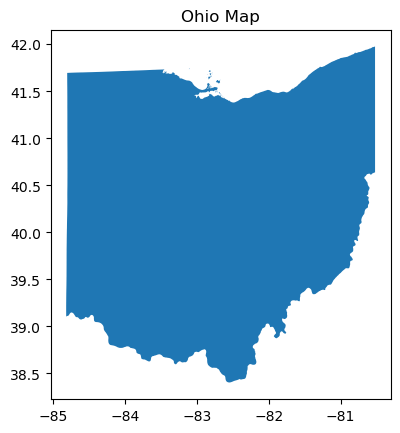

In [20]:
# Get Ohio boundary

# Unzip Ohio precint shapefile data
path = "project_data/Ohio_Boundary"

if not os.path.exists(path):
    with zipfile.ZipFile("project_data/Ohio_Boundary.zip", "r") as zip_ref:
        zip_ref.extractall("project_data/Ohio_Boundary")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

# Get data
gdf_ohio = gpd.read_file("project_data/Ohio_Boundary/Ohio_Boundary.shp")

# Reprojecting to epsg:4326
gdf_ohio_proj = gdf_ohio.to_crs(epsg=4326)

# Map
gdf_ohio_proj.plot()

plt.title("Ohio Map")
plt.show()

In [21]:
# Get land coverage data

# Unzip Ohio area land coverage data
path = "project_data/Land_Coverage"

if not os.path.exists(path):
    with zipfile.ZipFile("project_data/land_coverage.zip", "r") as zip_ref:
        zip_ref.extractall("project_data/Land_Coverage")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")


Unzipped folder already exists. Skipping extraction.


In [22]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import mapping

# Get land coerage data
tif_path = "./project_data/Land_Coverage/Annual_NLCD_LndCov_2018_CU_C1V0_87WvF2T5ssjRT0ljYilL.tiff"

# Reproject land coverage data onto ESPG: 4326
dst_crs = 'EPSG:4326'
reprojected_tif_path = "./project_data/land_coverage_reprojected.tif"

with rasterio.open(tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

# Create new reprojected .tif file called: land_coverage_reprojected.tif
    with rasterio.open(reprojected_tif_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


In [23]:

# Read Ohio boundary shapefile
shp_path = "project_data/Ohio_Boundary/Ohio_Boundary.shp"
ohio = gpd.read_file(shp_path)

# Reproject Ohio to espg=4326
ohio = ohio.to_crs(dst_crs)
ohio_geom = [mapping(geom) for geom in ohio.geometry]

# Clip reprojected .tif path with shape file of Ohio
with rasterio.open(reprojected_tif_path) as src:
    out_image, out_transform = mask(
        dataset=src,
        shapes=ohio_geom,
        crop=True,
        all_touched=True
    )

    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Create new clipped .tif file called: land_coverage_oh.tif
    with rasterio.open("./project_data/land_coverage_oh.tif", "w", **out_meta) as dest:
        dest.write(out_image)

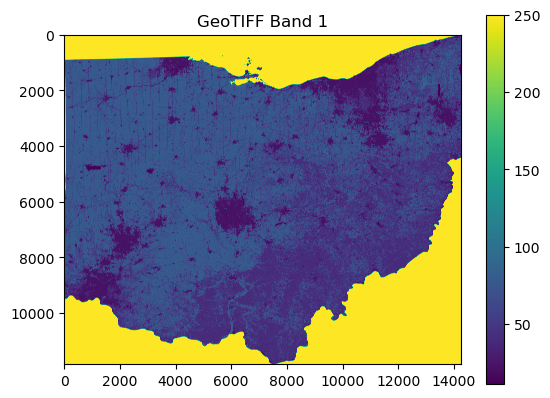

In [24]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open("./project_data/land_coverage_oh.tif") as src:
    image = src.read(1)  # Read the first band

# Preview to ensure masking was successful
plt.imshow(image)
plt.colorbar()
plt.title("GeoTIFF Band 1")
plt.show()

In [32]:
# Get Ohio land coverage .tif file
raster_path = "./project_data/land_coverage_oh.tif"

# Get geometry data for each congressional district
urbanization_cd_gdf = geometry_summary.copy()
# cd_geom.head(20)

# Make sure they have the same projection
with rasterio.open("./project_data/land_coverage_oh.tif") as src:
    print(src.crs)
    print(urbanization_cd_gdf.crs)

EPSG:4326
EPSG:4326


In [33]:
from rasterstats import zonal_stats

# Get pixel value counts per district
stats = zonal_stats(
    vectors=urbanization_cd_gdf,
    raster=raster_path,
    stats=None,  # no mean/sum, just raw counts
    categorical=True,
    nodata=0  # exclude nodata pixels (adjust if your nodata value is different)
)


In [34]:
# Add stats to the GeoDataFrame
urbanization_cd_gdf["dev_21"] = [s.get(21, 0) for s in stats]
urbanization_cd_gdf["dev_22"] = [s.get(22, 0) for s in stats]
urbanization_cd_gdf["dev_23"] = [s.get(23, 0) for s in stats]
urbanization_cd_gdf["dev_24"] = [s.get(24, 0) for s in stats]

# Add total developed area (pixel count)
urbanization_cd_gdf["dev_total"] = urbanization_cd_gdf[["dev_21", "dev_22", "dev_23", "dev_24"]].sum(axis=1)

# Total land pixels per district
urbanization_cd_gdf["total_pixels"] = [sum(s.values()) for s in stats]

# Calculate % developed for a measure of urbanization
urbanization_cd_gdf["urbanization_pct"] = (urbanization_cd_gdf["dev_total"] / urbanization_cd_gdf["total_pixels"]) * 100

urbanization_cd_gdf.head(20)


,CD116FP,geometry,dev_21,dev_22,dev_23,dev_24,dev_total,total_pixels,urbanization_pct
195,01,"POLYGON ((-84.82029 39.15651, -84.82028 39.156...",320239,303568,179115,61165,864087,2069802,41.747327
196,07,"MULTIPOLYGON (((-82.46660 40.74394, -82.46617 ...",822167,651327,198711,48509,1720714,11777644,14.610002
197,02,"POLYGON ((-84.57396 39.21136, -84.57393 39.212...",697411,395501,152056,43501,1288469,9609169,13.408745
198,14,"POLYGON ((-81.67048 41.31175, -81.67044 41.313...",732843,488987,204518,52196,1478544,10443970,14.156915
199,06,"POLYGON ((-83.10282 38.88755, -83.10145 38.887...",1508270,583785,207947,42792,2342794,21785273,10.754026
200,03,"POLYGON ((-83.17438 39.97486, -83.17416 39.975...",78763,189313,228706,81780,578562,696188,83.104276
201,10,"POLYGON ((-84.48537 39.91849, -84.48445 39.918...",323894,409364,227353,67558,1028169,3389044,30.338025
202,04,"POLYGON ((-84.57688 40.51637, -84.57684 40.516...",561128,999763,273890,77111,1911892,14270220,13.397775
203,05,"POLYGON ((-84.80620 41.67458, -84.80614 41.674...",433450,1359933,302855,77767,2174005,17234707,12.614111
204,16,"POLYGON ((-82.12933 40.99181, -82.12844 40.991...",510892,474887,186859,46567,1219205,3700509,32.946954


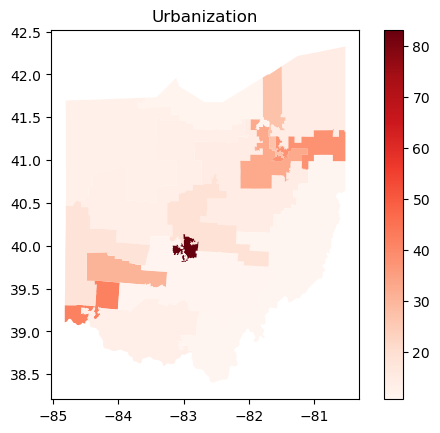

In [35]:
# Map
urbanization_cd_gdf.plot(column='urbanization_pct', cmap='Reds', legend=True)
plt.title("Urbanization")
plt.show()

### Merge All datasets

In [ ]:
# CDs & their geometry
geometry_summary.head()
# Data to merge other stuff on to

# Voter turnout data
gdf_turnout.head(20)
# Merge 'Voter Turnout Percentage' on CD116FP

# Age data
age_cd_gdf.head()
# Merge '18-29', '30-44', '45-64', '65 and older' on CD116FP

# Sex & poverty data
sex_poverty_cd_gdf.head()
# Merge 'Women', 'In Poverty' on CD116FP

# Education data
education_cd_gdf.head()
# Merge 'Did not finish high school', 'Bachelors or more' on CD116FP

# Race data
race_cd_gdf.head()
# Merge 'White', 'Black', 'Asian', 'Hispanic' on CD116FP

# Urbanization data
urbanization_cd_gdf.head()
# Merge 'urbanization_pct' on CD116FP

,CD116FP,geometry
195,01,"POLYGON ((-84.82029 39.15651, -84.82028 39.156..."
196,07,"MULTIPOLYGON (((-82.46660 40.74394, -82.46617 ..."
197,02,"POLYGON ((-84.57396 39.21136, -84.57393 39.212..."
198,14,"POLYGON ((-81.67048 41.31175, -81.67044 41.313..."
199,06,"POLYGON ((-83.10282 38.88755, -83.10145 38.887..."


In [ ]:
# Start with the geometry data as the base GeoDataFrame
merged_gdf = geometry_summary.copy()

# Merge turnout data
merged_gdf = merged_gdf.merge(
    gdf_turnout[['CD116FP', 'Voter Turnout Percentage']],
    on='CD116FP',
    how='left'
)

# Merge age data
merged_gdf = merged_gdf.merge(
    age_cd_gdf[['CD116FP', '18-29', '30-44', '45-64', '65 and older']],
    on='CD116FP',
    how='left'
)

# Merge sex & poverty data
merged_gdf = merged_gdf.merge(
    sex_poverty_cd_gdf[['CD116FP', 'Women', 'In Poverty']],
    on='CD116FP',
    how='left'
)

# Merge education data
merged_gdf = merged_gdf.merge(
    education_cd_gdf[['CD116FP', 'Did not finish high school', 'Bachelors or more']],
    on='CD116FP',
    how='left'
)

# Merge race data
merged_gdf = merged_gdf.merge(
    race_cd_gdf[['CD116FP', 'White', 'Black', 'Asian', 'Hispanic']],
    on='CD116FP',
    how='left'
)

# Merge urbanization data
merged_gdf = merged_gdf.merge(
    urbanization_cd_gdf[['CD116FP', 'urbanization_pct']],
    on='CD116FP',
    how='left'
)

merged_gdf.head(20)

,CD116FP,geometry,Voter Turnout Percentage,18-29,30-44,45-64,65 and older,Women,In Poverty,Did not finish high school,Bachelors or more,White,Black,Asian,Hispanic,urbanization_pct
0,01,"POLYGON ((-84.82029 39.15651, -84.82028 39.156...",57.441623,21.3,23.5,34.8,20.4,51.5,11.7,9.3,32.6,75.3,20.300000,1.8,1.7,41.747327
1,07,"MULTIPOLYGON (((-82.46660 40.74394, -82.46617 ...",56.067900,18.3,22.8,34.7,24.1,51.9,10.1,11.9,19.8,94.1,3.514391,0.5,1.3,14.610002
2,02,"POLYGON ((-84.57396 39.21136, -84.57393 39.212...",57.572041,19.7,24.2,34.7,21.3,52.1,11.9,9.3,30.2,88.1,8.800000,1.0,1.2,13.408745
3,14,"POLYGON ((-81.67048 41.31175, -81.67044 41.313...",62.144496,16.5,21.0,36.6,25.9,51.9,6.8,8.1,34.7,92.1,4.811186,1.5,2.1,14.156915
4,06,"POLYGON ((-83.10282 38.88755, -83.10145 38.887...",54.016244,17.0,21.2,36.3,25.4,50.3,14.9,11.2,15.8,95.7,2.189251,NaN,0.8,10.754026
5,03,"POLYGON ((-83.17438 39.97486, -83.17416 39.975...",49.146792,27.4,27.2,30.9,14.5,53.3,16.1,10.4,26.6,60.7,31.400000,2.9,3.6,83.104276
6,10,"POLYGON ((-84.48537 39.91849, -84.48445 39.918...",55.197831,21.5,22.4,33.0,23.1,52.3,13.6,8.8,28.1,79.6,15.900000,1.6,1.9,30.338025
7,04,"POLYGON ((-84.57688 40.51637, -84.57684 40.516...",55.515694,19.8,22.2,35.4,22.6,50.3,10.4,9.0,17.1,91.6,5.435147,0.7,3.2,13.397775
8,05,"POLYGON ((-84.80620 41.67458, -84.80614 41.674...",56.732935,19.7,22.0,34.7,23.6,51.7,9.3,7.5,25.0,93.0,2.921130,0.9,4.1,12.614111
9,16,"POLYGON ((-82.12933 40.99181, -82.12844 40.991...",60.812392,17.0,21.6,35.3,26.2,51.4,6.2,6.0,33.0,93.7,3.126785,1.5,1.8,32.946954


In [ ]:
merged_gdf.drop(columns='geometry').to_csv('./data2/cd_2018.csv', index=False)